#LSTM and ARIMA with MACD (Moving Average Convergence Divergence) technical indicator


**Students:** Gabriel Sposito and Thomas Frentzel

**LSTM**


In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=8fc9b1d1224d947ad58a8ff94804fe45f102ea9d1d74b7a95ee172727ac4cecb
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from ta.trend import CCIIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import PSARIndicator

In [3]:
base = pd.read_csv('Intel 5Y.csv')
base.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$23.32,58650460,$22.25,$23.42,$22.045
1,10/07/2024,$22.38,54928670,$22.40,$22.65,$22.0209
2,10/04/2024,$22.59,49966930,$22.70,$22.91,$22.30
3,10/03/2024,$22.26,49565930,$22.14,$22.73,$21.65
4,10/02/2024,$22.39,59033900,$22.67,$23.0668,$22.35


In [4]:
# Removing nule results
base.dropna()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$23.32,58650460,$22.25,$23.42,$22.045
1,10/07/2024,$22.38,54928670,$22.40,$22.65,$22.0209
2,10/04/2024,$22.59,49966930,$22.70,$22.91,$22.30
3,10/03/2024,$22.26,49565930,$22.14,$22.73,$21.65
4,10/02/2024,$22.39,59033900,$22.67,$23.0668,$22.35
...,...,...,...,...,...,...
1253,10/15/2019,$52.65,18970760,$51.93,$53.07,$51.83
1254,10/14/2019,$51.64,16425530,$51.90,$51.95,$51.44
1255,10/11/2019,$52.09,24167110,$52.00,$52.79,$51.82
1256,10/10/2019,$51.11,14611660,$50.41,$51.775,$50.40


In [5]:
# Removing $
base['Close/Last'] = base['Close/Last'].str.replace('$', '')
base['Open'] = base['Open'].str.replace('$', '')
base['High'] = base['High'].str.replace('$', '')
base['Low'] = base['Low'].str.replace('$', '')

# Converting str to float
base['Close/Last'] = base['Close/Last'].astype(float)
base['Open'] = base['Open'].astype(float)
base['High'] = base['High'].astype(float)
base['Low'] = base['Low'].astype(float)

In [6]:
cci = CCIIndicator(high=base['High'], low=base['Low'], close=base['Close/Last'], window=20, constant=0.015)
base['CCI'] = cci.cci()

sma_tp = base['High'] + base['Low'] + base['Close/Last'] / 3
sma_tp = sma_tp.rolling(window=20).mean()
mean_deviation = np.mean(np.abs(base['Close/Last'] - sma_tp))

rsi = RSIIndicator(close=base['Close/Last'], window=14)
base['RSI'] = rsi.rsi()

macd = MACD(close=base['Close/Last'], window_slow=26, window_fast=12, window_sign=9)
base['MACD'] = macd.macd()
base['MACD_Signal'] = macd.macd_signal()
base['MACD_Diff'] = macd.macd_diff()

psar = PSARIndicator(high=base['High'], low=base['Low'], close=base['Close/Last'])
base['Parabolic_SAR'] = psar.psar()

bollinger = BollingerBands(close=base['Close/Last'], window=20, window_dev=2)
base['Bollinger_High'] = bollinger.bollinger_hband()
base['Bollinger_Low'] = bollinger.bollinger_lband()
base['Bollinger_Middle'] = bollinger.bollinger_mavg()
base['Bollinger_Width'] = bollinger.bollinger_wband()

base.dropna()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,21.41,57028870,21.072,21.440,21.0700,109.236141,54.112274,-0.365474,-0.606827,0.241353,19.455067,21.792245,18.378755,20.08550,16.994799
34,08/20/2024,20.99,84161270,21.210,21.230,20.8200,82.525909,51.262625,-0.290474,-0.543556,0.253082,19.561664,21.823466,18.369534,20.09650,17.186732
35,08/19/2024,21.52,65956300,20.885,21.860,20.8350,124.006703,54.517618,-0.186125,-0.472070,0.285945,19.663997,21.834038,18.363962,20.09900,17.264916
36,08/16/2024,20.87,48582660,20.530,20.895,20.4101,57.383431,50.098507,-0.154100,-0.408476,0.254376,19.762238,21.828382,18.365618,20.09700,17.230254
37,08/15/2024,20.69,84814880,20.320,21.060,20.2300,46.431701,48.916029,-0.141612,-0.355103,0.213491,19.856548,21.886088,18.410912,20.14850,17.247812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,10/15/2019,52.65,18970760,51.930,53.070,51.8300,-68.893127,32.656899,-1.587661,-1.307755,-0.279905,53.235976,60.363386,49.940114,55.15175,18.899260
1254,10/14/2019,51.64,16425530,51.900,51.950,51.4400,-81.645295,28.543524,-1.611303,-1.368465,-0.242838,53.070000,60.025053,49.607447,54.81625,19.004594
1255,10/11/2019,52.09,24167110,52.000,52.790,51.8200,-59.811562,32.615978,-1.575567,-1.409885,-0.165681,51.029100,59.591590,49.422910,54.50725,18.655647
1256,10/10/2019,51.11,14611660,50.410,51.775,50.4000,-83.377075,28.770423,-1.607790,-1.449466,-0.158323,52.790000,59.176915,49.143585,54.16025,18.525264


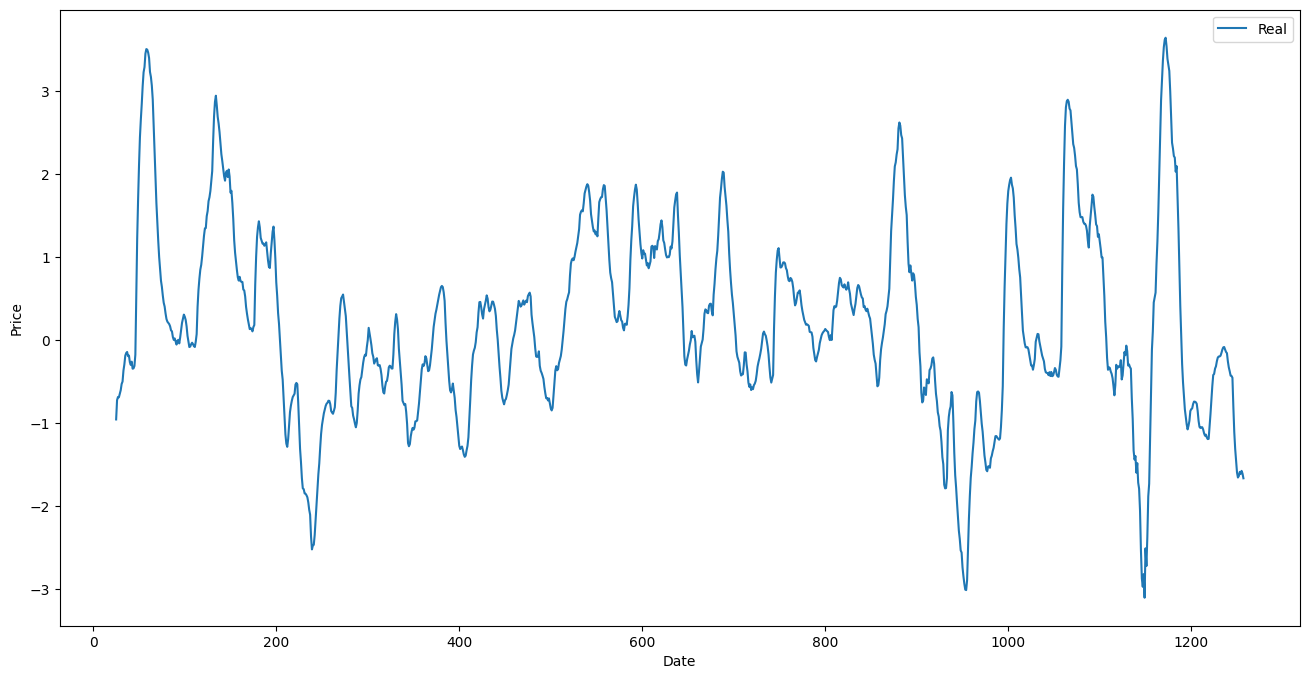

In [7]:
plt.figure(figsize=(16,8))
plt.plot(base['MACD'], label='Real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

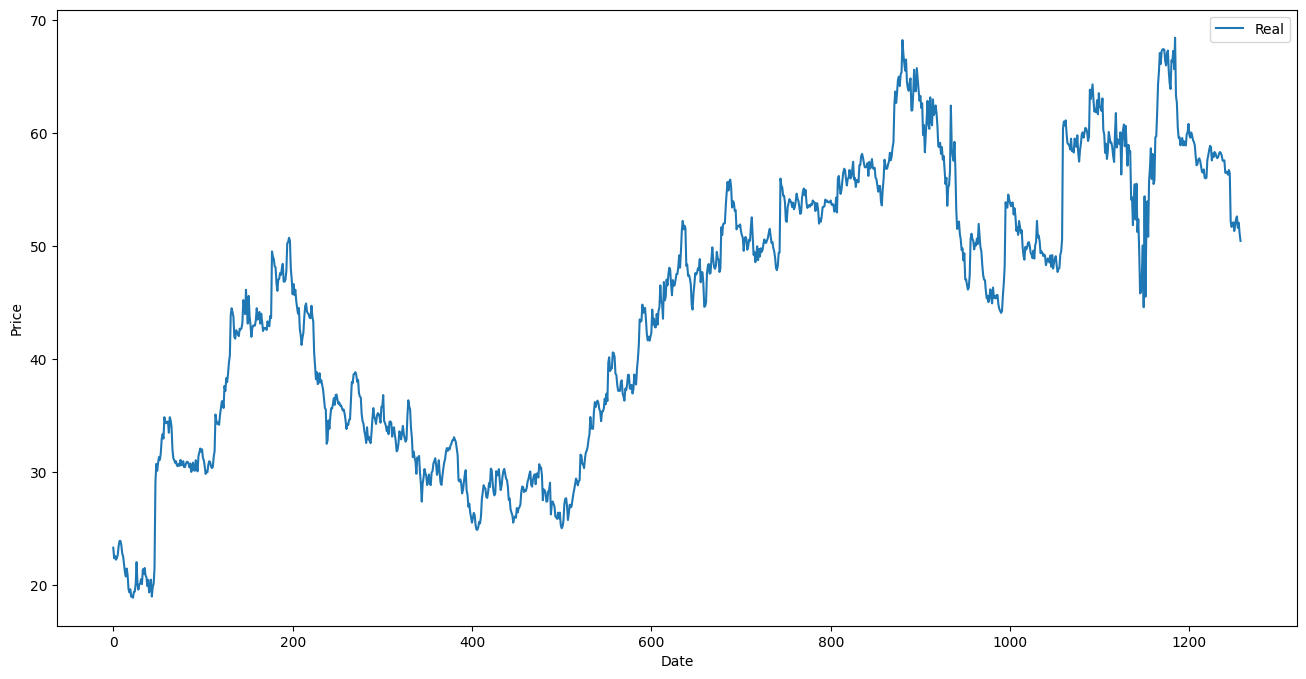

In [8]:
plt.figure(figsize=(16,8))
plt.plot(base['Close/Last'], label='Real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [9]:
# Converting indicator values ​​to numeric values ​​and removing NaN values
base = base.replace([np.inf, -np.inf], np.nan)
base = base.dropna()

In [10]:
# Normalizing the data of real values
scaler_real_value = MinMaxScaler(feature_range=(0, 1))
scaled_data_real_value = scaler_real_value.fit_transform(np.array(base['Close/Last']).reshape(-1, 1))

In [11]:
window_size_real_value = 10
forecasters_real_value = []
real_value_of_prices = []
for i in range(window_size_real_value, len(base)):
    forecasters_real_value.append(scaled_data_real_value[i - window_size_real_value:i, 0])
    real_value_of_prices.append(scaled_data_real_value[i, 0])

forecasters_real_value, real_value_of_prices = np.array(forecasters_real_value), np.array(real_value_of_prices)
forecasters_real_value = np.reshape(forecasters_real_value, (forecasters_real_value.shape[0], forecasters_real_value.shape[1], 1))

In [12]:
#dividindo a coluna close/last em 70% treino e 30% teste com trai_test_split
Xtrain_real_lstm, Xtest_real_lstm, ytrain_real_lstm, ytest_real_lstm = train_test_split(forecasters_real_value, real_value_of_prices,
                                                                                        test_size = 0.3, shuffle = False)

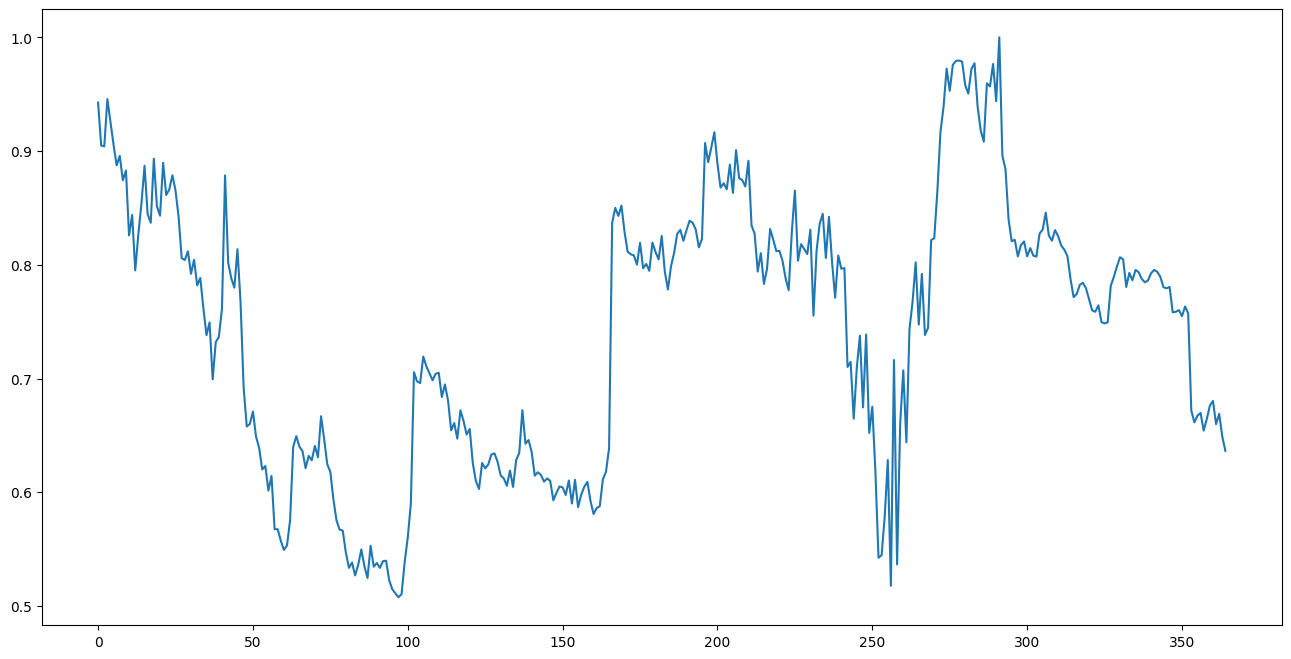

In [13]:
#plotando grafico dos valores de teste
plt.figure(figsize=(16,8))
plt.plot(ytest_real_lstm)
plt.show()

In [14]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(base['MACD']).reshape(-1, 1))

In [15]:
window_size = 10
forecasters = []
real_value = []
for i in range(window_size, len(base)):
    forecasters.append(scaled_data[i - window_size:i, 0])
    real_value.append(scaled_data[i, 0])

forecasters, real_value = np.array(forecasters), np.array(real_value)
forecasters = np.reshape(forecasters, (forecasters.shape[0], forecasters.shape[1], 1))

In [16]:
# Separating data between training and testing
X_train, X_test, y_train, y_test = train_test_split(forecasters, real_value, test_size=0.3, shuffle=False)

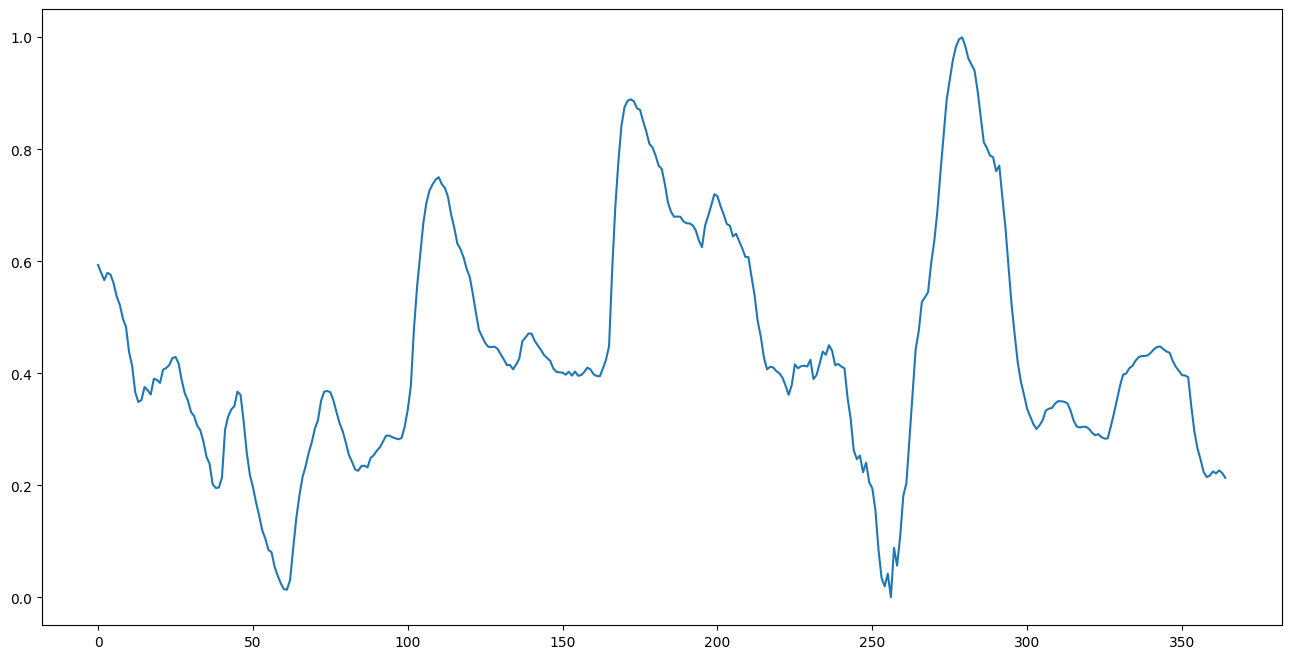

In [17]:
# Showing test set in graph
plt.figure(figsize=(16, 8))
plt.plot(y_test)
plt.show()

In [18]:
# LSTM model

lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(forecasters.shape[1], 1)))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=50, return_sequences=True))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=50))
lstm.add(Dropout(0.3))
lstm.add(Dense(units=1))
lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.1202 - mean_absolute_error: 0.2899 - val_loss: 0.0196 - val_mean_absolute_error: 0.1012
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0129 - mean_absolute_error: 0.0875 - val_loss: 0.0200 - val_mean_absolute_error: 0.1111
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0123 - mean_absolute_error: 0.0868 - val_loss: 0.0174 - val_mean_absolute_error: 0.0975
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0118 - mean_absolute_error: 0.0846 - val_loss: 0.0166 - val_mean_absolute_error: 0.0938
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0122 - mean_absolute_error: 0.0838 - val_loss: 0.0159 - val_mean_absolute_error: 0.0911
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0093 - mean_absolute_error: 0.0747 - val_loss: 0.0155 - val_mean_absolute_error: 0.0904
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0101 - mean_absolute_error: 0.0753 - v

In [20]:
test_predictions = lstm.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


In [21]:
# Transforming test values ​​back to original values
y_orig_test = scaler.inverse_transform(y_test.reshape(-1, 1))

#escalonando valores de teste
ytest_real_lstm = scaler_real_value.inverse_transform(ytest_real_lstm.reshape(-1, 1))

In [22]:
test_predictions = test_predictions.ravel()  # Converts to 1D
y_orig_test = y_orig_test.ravel()
ytest_real_lstm = ytest_real_lstm.ravel()

In [23]:
test_size_L = len(y_test)

close_test_L = base['Close/Last'].tail(test_size_L)

In [24]:
# Inverse MACD formula
def MACD_inverse(macd_values, close_values, short_window=12, long_window=26):
    original_prices = []
    for i in range(len(macd_values)):
        if i < long_window:
            original_prices.append(close_values[i])
            continue
        # Calculate moving averages
        short_ma = np.mean(close_values[max(0, i-short_window):i+1]) # Average of the last 'short_window' prices
        long_ma = np.mean(close_values[max(0, i-long_window):i+1])  # Average of the last 'long_window' prices
        # Estimate adjusted price
        estimated_price = close_values[i]
        price_adjustment = (macd_values[i] / 100) * (short_ma - long_ma)  # Estimate adjusted price
        estimated_price += price_adjustment
        original_prices.append(estimated_price)
    return np.array(original_prices)

# Making sure the data is in array format
close_test_L = close_test_L.values if isinstance(close_test_L, pd.Series) else close_test_L

In [25]:
# Inverting the values ​​test_predictions and y_orig_teste by the inverse MACD formula
test_predictions_inverted = MACD_inverse(test_predictions, close_test_L)
y_orig_test_inverted = MACD_inverse(y_orig_test, close_test_L)

min_length = min(len(ytest_real_lstm), len(test_predictions_inverted))
ytest_real_lstm = ytest_real_lstm[:min_length]
test_predictions_inverted = test_predictions_inverted[:min_length]

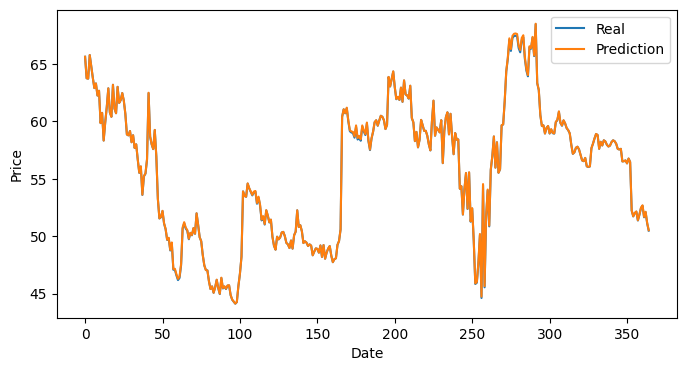

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(ytest_real_lstm)), ytest_real_lstm, label='Real')
plt.plot(range(len(test_predictions_inverted)), test_predictions_inverted, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [27]:
# R2 Score
r2 = r2_score(ytest_real_lstm, test_predictions_inverted)
print(f'R2 Score: {r2}')

# RMSE
rmse = np.sqrt(np.mean((ytest_real_lstm - test_predictions_inverted) ** 2))
print(f'RMSE: {rmse}')

R2 Score: 0.9999328859604963
RMSE: 0.04787930946901313


**ARIMA**

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from ta.trend import CCIIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import PSARIndicator
from math import sqrt

In [29]:
base_A = pd.read_csv('Intel 5Y.csv')
base_A.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$23.32,58650460,$22.25,$23.42,$22.045
1,10/07/2024,$22.38,54928670,$22.40,$22.65,$22.0209
2,10/04/2024,$22.59,49966930,$22.70,$22.91,$22.30
3,10/03/2024,$22.26,49565930,$22.14,$22.73,$21.65
4,10/02/2024,$22.39,59033900,$22.67,$23.0668,$22.35


In [30]:
base_A.dtypes

,0
Date,object
Close/Last,object
Volume,int64
Open,object
High,object
Low,object


In [31]:
# Removing $
base_A['Close/Last'] = base_A['Close/Last'].str.replace('$', '')
base_A['Open'] = base_A['Open'].str.replace('$', '')
base_A['High'] = base_A['High'].str.replace('$', '')
base_A['Low'] = base_A['Low'].str.replace('$', '')

# Converting str to float
base_A['Close/Last'] = base_A['Close/Last'].astype(float)
base_A['Open'] = base_A['Open'].astype(float)
base_A['High'] = base_A['High'].astype(float)
base_A['Low'] = base_A['Low'].astype(float)

In [32]:
cci = CCIIndicator(high=base_A['High'], low=base_A['Low'], close=base_A['Close/Last'], window=20, constant=0.015)
base_A['CCI'] = cci.cci()

sma_tp = base_A['High'] + base_A['Low'] + base_A['Close/Last'] / 3
sma_tp = sma_tp.rolling(window=20).mean()
mean_deviation = np.mean(np.abs(base_A['Close/Last'] - sma_tp))

rsi = RSIIndicator(close=base_A['Close/Last'], window=14)
base_A['RSI'] = rsi.rsi()

macd = MACD(close=base_A['Close/Last'], window_slow=26, window_fast=12, window_sign=9)
base_A['MACD'] = macd.macd()
base_A['MACD_Signal'] = macd.macd_signal()
base_A['MACD_Diff'] = macd.macd_diff()

psar = PSARIndicator(high=base_A['High'], low=base_A['Low'], close=base_A['Close/Last'])
base_A['Parabolic_SAR'] = psar.psar()

bollinger = BollingerBands(close=base_A['Close/Last'], window=20, window_dev=2)
base_A['Bollinger_High'] = bollinger.bollinger_hband()
base_A['Bollinger_Low'] = bollinger.bollinger_lband()
base_A['Bollinger_Middle'] = bollinger.bollinger_mavg()
base_A['Bollinger_Width'] = bollinger.bollinger_wband()

base_A.dropna()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,21.41,57028870,21.072,21.440,21.0700,109.236141,54.112274,-0.365474,-0.606827,0.241353,19.455067,21.792245,18.378755,20.08550,16.994799
34,08/20/2024,20.99,84161270,21.210,21.230,20.8200,82.525909,51.262625,-0.290474,-0.543556,0.253082,19.561664,21.823466,18.369534,20.09650,17.186732
35,08/19/2024,21.52,65956300,20.885,21.860,20.8350,124.006703,54.517618,-0.186125,-0.472070,0.285945,19.663997,21.834038,18.363962,20.09900,17.264916
36,08/16/2024,20.87,48582660,20.530,20.895,20.4101,57.383431,50.098507,-0.154100,-0.408476,0.254376,19.762238,21.828382,18.365618,20.09700,17.230254
37,08/15/2024,20.69,84814880,20.320,21.060,20.2300,46.431701,48.916029,-0.141612,-0.355103,0.213491,19.856548,21.886088,18.410912,20.14850,17.247812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,10/15/2019,52.65,18970760,51.930,53.070,51.8300,-68.893127,32.656899,-1.587661,-1.307755,-0.279905,53.235976,60.363386,49.940114,55.15175,18.899260
1254,10/14/2019,51.64,16425530,51.900,51.950,51.4400,-81.645295,28.543524,-1.611303,-1.368465,-0.242838,53.070000,60.025053,49.607447,54.81625,19.004594
1255,10/11/2019,52.09,24167110,52.000,52.790,51.8200,-59.811562,32.615978,-1.575567,-1.409885,-0.165681,51.029100,59.591590,49.422910,54.50725,18.655647
1256,10/10/2019,51.11,14611660,50.410,51.775,50.4000,-83.377075,28.770423,-1.607790,-1.449466,-0.158323,52.790000,59.176915,49.143585,54.16025,18.525264


In [33]:
# Converting indicator values ​​to numeric values ​​and removing NaN values
base_A = base_A.replace([np.inf, -np.inf], np.nan)
base_A = base_A.dropna()

In [34]:
base_A.head()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,21.41,57028870,21.072,21.440,21.0700,109.236141,54.112274,-0.365474,-0.606827,0.241353,19.455067,21.792245,18.378755,20.0855,16.994799
34,08/20/2024,20.99,84161270,21.210,21.230,20.8200,82.525909,51.262625,-0.290474,-0.543556,0.253082,19.561664,21.823466,18.369534,20.0965,17.186732
35,08/19/2024,21.52,65956300,20.885,21.860,20.8350,124.006703,54.517618,-0.186125,-0.472070,0.285945,19.663997,21.834038,18.363962,20.0990,17.264916
36,08/16/2024,20.87,48582660,20.530,20.895,20.4101,57.383431,50.098507,-0.154100,-0.408476,0.254376,19.762238,21.828382,18.365618,20.0970,17.230254
37,08/15/2024,20.69,84814880,20.320,21.060,20.2300,46.431701,48.916029,-0.141612,-0.355103,0.213491,19.856548,21.886088,18.410912,20.1485,17.247812


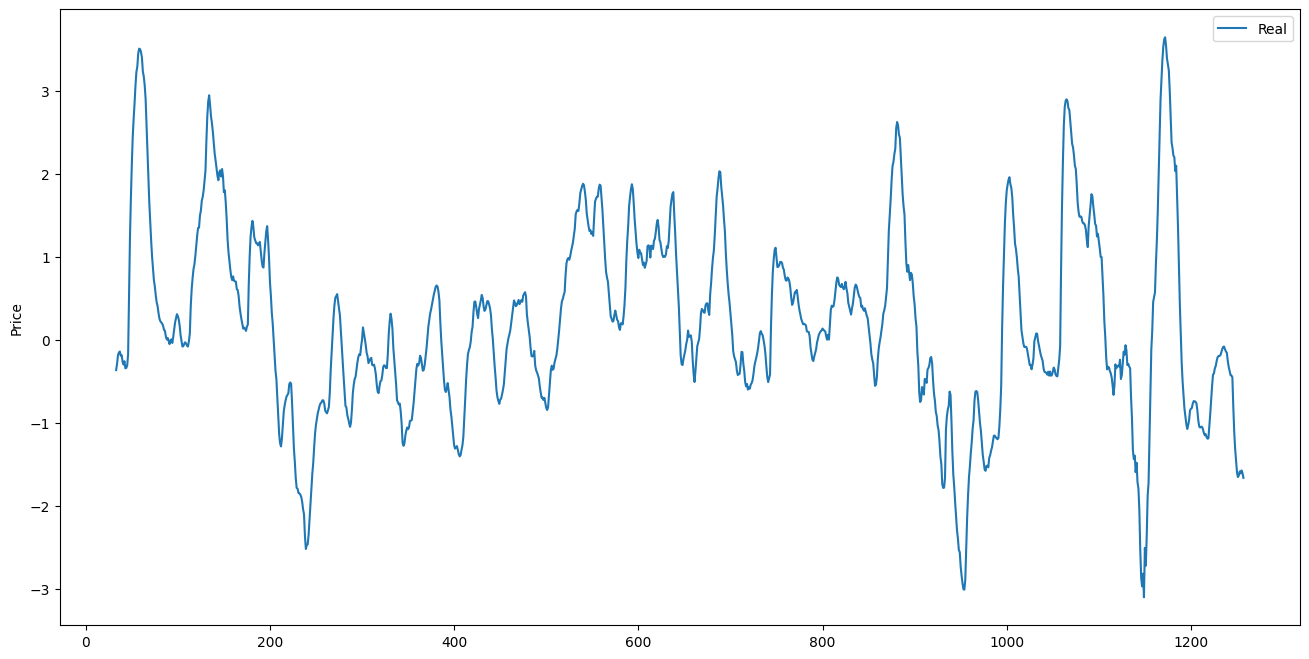

In [35]:
# Plotting MACD
plt.figure(figsize=(16,8))
plt.plot(base_A['MACD'], label='Real')
plt.ylabel('Price')
plt.legend()

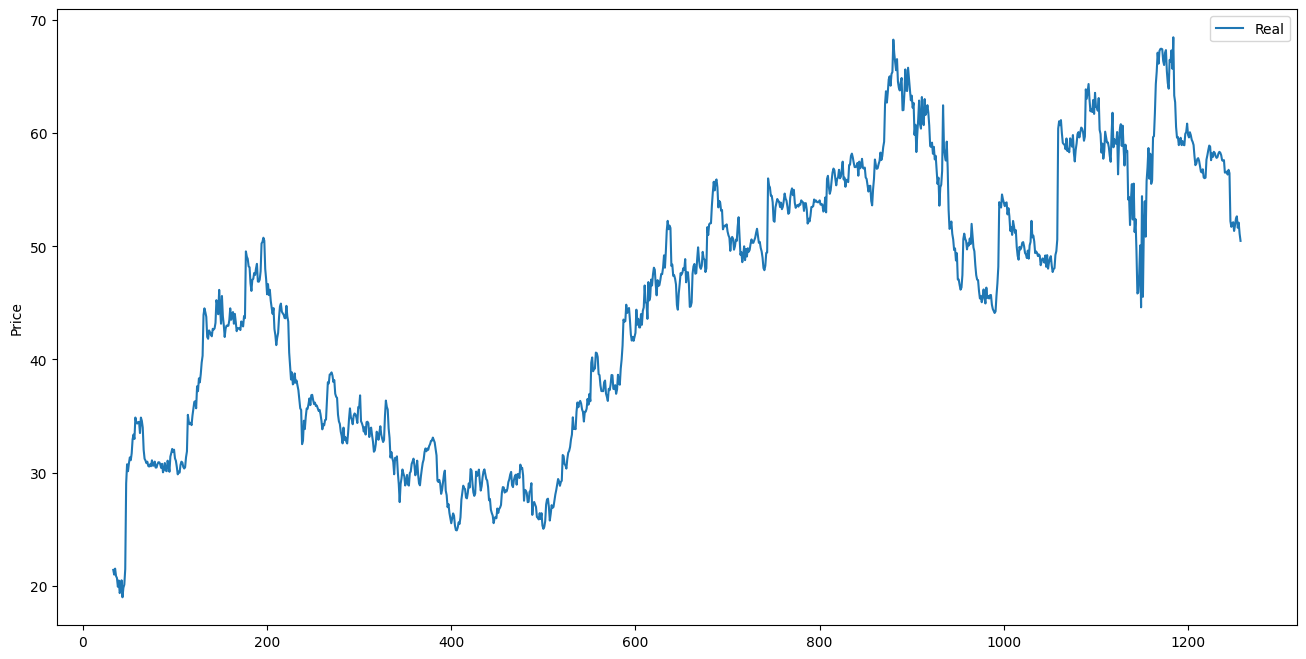

In [36]:
plt.figure(figsize=(16,8))
plt.plot(base_A['Close/Last'], label='Real')
plt.ylabel('Price')
plt.legend()

In [37]:
X_R = base_A['Close/Last'].values
size_R = int(len(X_R) * 0.70)
train_R, test_R = X_R[0:size_R], X_R[size_R:len(X_R)]
history_R = [x_r for x_r in train_R]
forecasts_R = list()

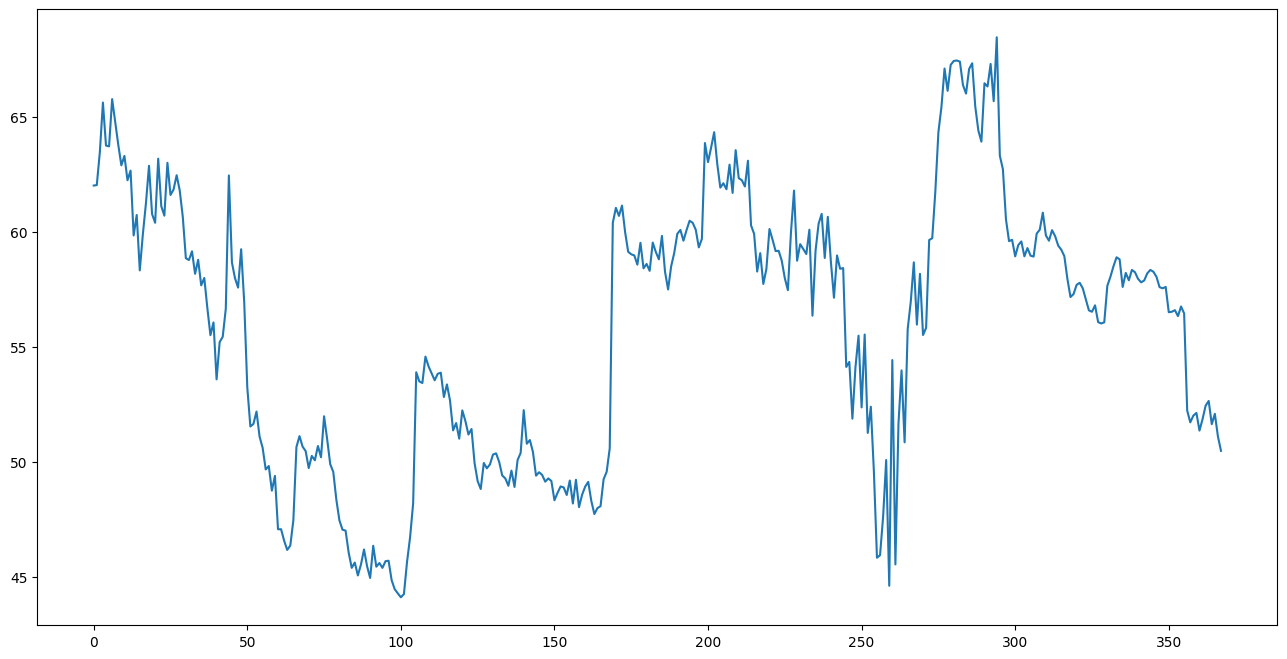

In [38]:
#Test Grafic
plt.figure(figsize=(16, 8))
plt.plot(test_R)
plt.show()

In [39]:
#Addfuller for MACD
result = adfuller(base_A['MACD'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -5.737422515618103
p-value: 6.390360227543807e-07


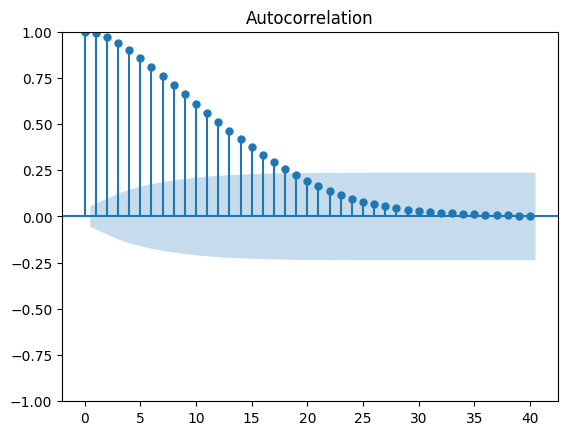

In [40]:
plot_acf(base_A['MACD'], lags=40)
plt.show()

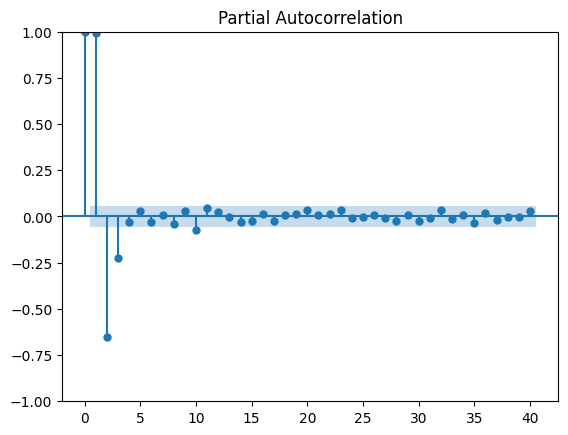

In [41]:
plot_pacf(base_A['MACD'], lags=40)
plt.show()

In [42]:
X = base_A['MACD'].values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
forecasts = list()

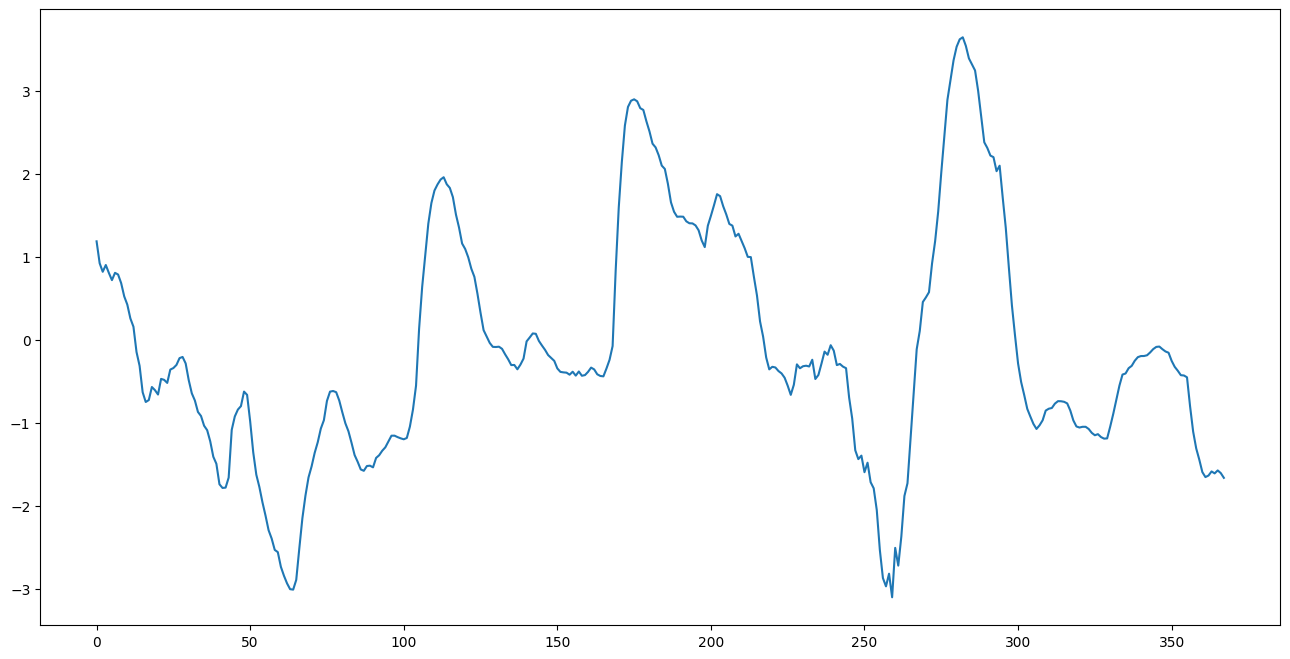

In [43]:
plt.figure(figsize=(16, 8))
plt.plot(test)
plt.show()

In [44]:
# ARIMA
for t in range(len(test)):
    model = ARIMA(history, order=(2, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    forecasts.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'Expected={yhat}, Observed={obs}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=1.4179314156422422, Observed=1.1872357761085226
Expected=0.9337064211121672, Observed=0.9228851547918708
Expected=0.7167235826257143, Observed=0.8201274297740753


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=0.7367641107104881, Observed=0.9017830306316483


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=0.9652403600775281, Observed=0.8063076976211221


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=0.7274770623800342, Observed=0.7195243717852904
Expected=0.6529942694245471, Observed=0.8072636535744806
Expected=0.8767236623686493, Observed=0.787033590548063
Expected=0.7697036839128156, Observed=0.6832404233273834
Expected=0.6025641268256101, Observed=0.5231376236721346
Expected=0.39807651198746186, Observed=0.4244458276610743
Expected=0.3487660034440392, Observed=0.2577278014112494


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=0.12970453989832087, Observed=0.157675469717951
Expected=0.08107921715577035, Observed=-0.14746724565107172
Expected=-0.38701179498411536, Observed=-0.31386148423761995
Expected=-0.44234102205378545, Observed=-0.6329012838796402
Expected=-0.8816485103990145, Observed=-0.7504065253783239
Expected=-0.846253492823299, Observed=-0.7270228083145724
Expected=-0.7088134581384014, Observed=-0.5695908612325482
Expected=-0.4473356213533801, Observed=-0.6072770467240431


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=-0.6242695565423427, Observed=-0.6601961145965944


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=-0.712843267631349, Observed=-0.4715692177492059
Expected=-0.3251928401180177, Observed=-0.4835388089058199
Expected=-0.4919623450392486, Observed=-0.5201128326449762
Expected=-0.5486028036477439, Observed=-0.3593646993050612
Expected=-0.2351210829197381, Observed=-0.34100801706660633
Expected=-0.32670442115505083, Observed=-0.3035945706738943
Expected=-0.2748878101968923, Observed=-0.22136358480297957
Expected=-0.15792772713781603, Observed=-0.20706450943627175
Expected=-0.19601230386069374, Observed=-0.28523971238900714
Expected=-0.34551690000827007, Observed=-0.4868272393475408
Expected=-0.6424577972427307, Observed=-0.6456000625845988
Expected=-0.7679991191568132, Observed=-0.7323240686810522
Expected=-0.7991385590026079, Observed=-0.8701012920480053
Expected=-0.9764817028086298, Observed=-0.9194697571697148
Expected=-0.9574210636278375, Observed=-1.0362174747759596
Expected=-1.126257266092846, Observed=-1.0903506726181575
Expected=-1.132187948220641, Observed=-1.224838498

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=-1.5537284027850191, Observed=-1.4953997036982116
Expected=-1.5610792122202017, Observed=-1.7424054889261242
Expected=-1.9327513020114555, Observed=-1.7868412979915647
Expected=-1.8228850490435062, Observed=-1.7829452361711375
Expected=-1.7795352172374848, Observed=-1.662252364532101
Expected=-1.5701173568436626, Observed=-1.0860713127974506
Expected=-0.639385580196125, Observed=-0.9246067131444065
Expected=-0.7969466401037001, Observed=-0.8418112950328336
Expected=-0.7794333606558659, Observed=-0.8000563515547228
Expected=-0.7676350919174955, Observed=-0.62500553998008
Expected=-0.49262763467346354, Observed=-0.664210681453163
Expected=-0.690959876474115, Observed=-0.9833120238442987
Expected=-1.2261722344771973, Observed=-1.3577268986653337
Expected=-1.6436820027692602, Observed=-1.6268242860759372
Expected=-1.832094805002999, Observed=-1.7760393413283992
Expected=-1.889593765308996, Observed=-1.9596575260267173
Expected=-2.0998417906046094, Observed=-2.1202739667330732
Expe

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=-1.1374481325108596, Observed=-1.0717752003714054
Expected=-0.9458249481608997, Observed=-0.9701437467841316
Expected=-0.8921238936114729, Observed=-0.7370690324717728
Expected=-0.558165006296508, Observed=-0.6254342103470307
Expected=-0.5391114620030348, Observed=-0.617795142182672
Expected=-0.6119241650551426, Observed=-0.631892223909361
Expected=-0.6426913488621679, Observed=-0.7322601115993947
Expected=-0.809205343503295, Observed=-0.8743459482614
Expected=-0.9834109868830224, Observed=-1.0076115359793647
Expected=-1.109946653342207, Observed=-1.1037300273711637
Expected=-1.1775437884216604, Observed=-1.2422418935342918
Expected=-1.348614589313663, Observed=-1.3900532770691214
Expected=-1.5036742202748612, Observed=-1.4716712752565897
Expected=-1.53440319428431, Observed=-1.563518182380605
Expected=-1.6340753905110064, Observed=-1.5801672613822504
Expected=-1.5930309746631786, Observed=-1.5225542348293288
Expected=-1.4783113519719302, Observed=-1.5182983965348242
Expected=

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=-0.2996459723799425, Observed=-0.3127457812065586
Expected=-0.30807732487567546, Observed=-0.32191315716469404
Expected=-0.3289721129191959, Observed=-0.24086864365993677
Expected=-0.17805736078786852, Observed=-0.47297486648486853
Expected=-0.6523143127354173, Observed=-0.42447717933647766
Expected=-0.3897616428960572, Observed=-0.28751201499702006
Expected=-0.18163689653955079, Observed=-0.14262464105586758
Expected=-0.031048017071619444, Observed=-0.18064593336914925
Expected=-0.2092333412510209, Observed=-0.06558402924571993
Expected=0.021638431923534235, Observed=-0.13104169377299257
Expected=-0.178986541883619, Observed=-0.3052772805818478
Expected=-0.43951495116531636, Observed=-0.29152707331720507
Expected=-0.28189304645306407, Observed=-0.32369967932562815
Expected=-0.3477290726723204, Observed=-0.3428240893968848
Expected=-0.35789834502629336, Observed=-0.6969207173513183
Expected=-0.9664878808119645, Observed=-0.9488548763771476
Expected=-1.1448168931737432, Observe

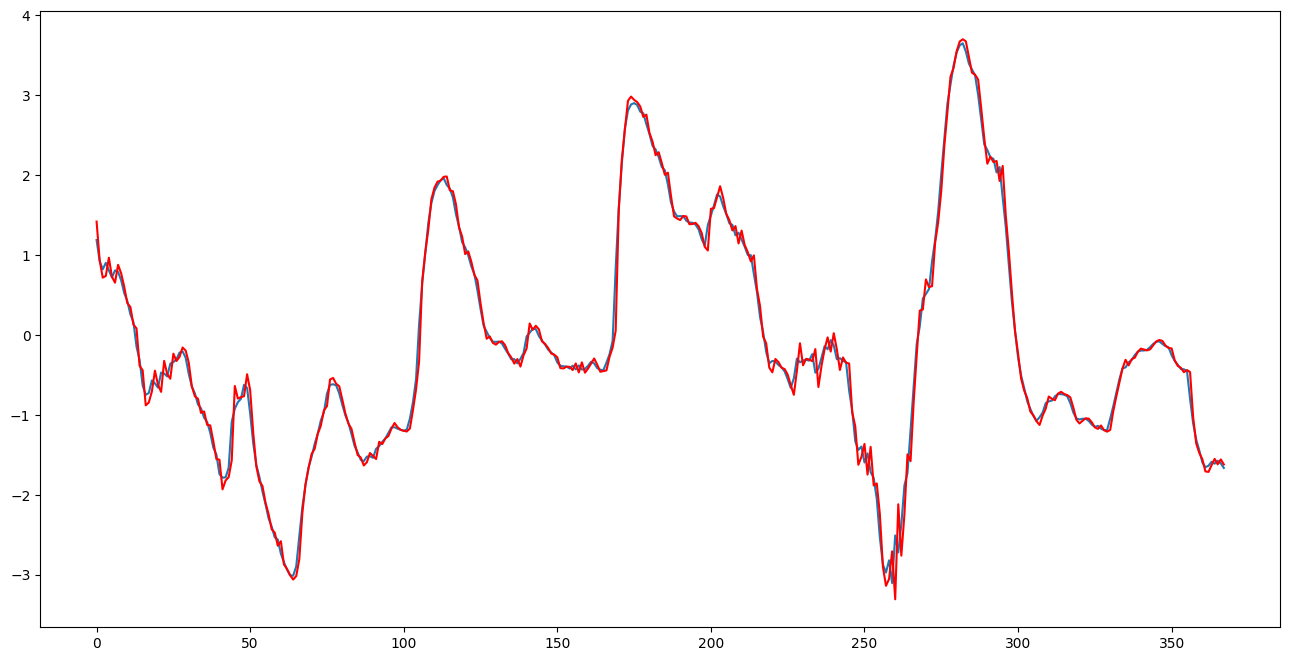

In [45]:
# Test and forecast set
plt.figure(figsize=(16, 8))
plt.plot(test)
plt.plot(forecasts, color='red')
plt.show()

In [46]:
# Ensuring that data is one-dimensional
test = test.ravel()
forecasts = np.array(forecasts).ravel()

In [47]:
# Getting the high, low and close values ​​from the test set for the MACD
test_size_A = len(test)

close_test_A = base_A['Close/Last'].tail(test_size_A)

In [48]:
print(test.shape)
print(forecasts.shape)

(368,)
(368,)


In [49]:
# Inverse MACD formula
def MACD_inverse_A(macd_values_A, close_values_A, short_window=12, long_window=26):
    original_prices = []
    for i in range(len(macd_values_A)):
        if i < long_window:
            original_prices.append(close_values_A[i])
            continue
        # Calculate moving averages
        short_ma = np.mean(close_values_A[max(0, i-short_window):i+1]) # Average of the last 'short_window' prices
        long_ma = np.mean(close_values_A[max(0, i-long_window):i+1])  # Average of the last 'long_window' prices
        # Estimate adjusted price
        estimated_price = close_values_A[i]
        price_adjustment = (macd_values_A[i] / 100) * (short_ma - long_ma) # Adjust based on difference
        estimated_price += price_adjustment
        original_prices.append(estimated_price)
    return np.array(original_prices)

# Making sure the data is in array format
close_test_A = close_test_A.values if isinstance(close_test_A, pd.Series) else close_test_A

In [50]:
test_inverted = MACD_inverse_A(test, close_test_A)
forecasts_inverted = MACD_inverse_A(forecasts, close_test_A)

min_length_R = min(len(test_R), len(forecasts_inverted))
test_R = test_R[:min_length_R]
forecasts_inverted = forecasts_inverted[:min_length_R]

In [51]:
# RMSE
rmse = sqrt(mean_squared_error(test_R, forecasts_inverted))
print(f'RMSE: {rmse}')

# R2 Score
r2 = r2_score(test_R, forecasts_inverted)
print(f'R2 Score: {r2}')

RMSE: 0.05101187823894019
R2 Score: 0.9999240219866976


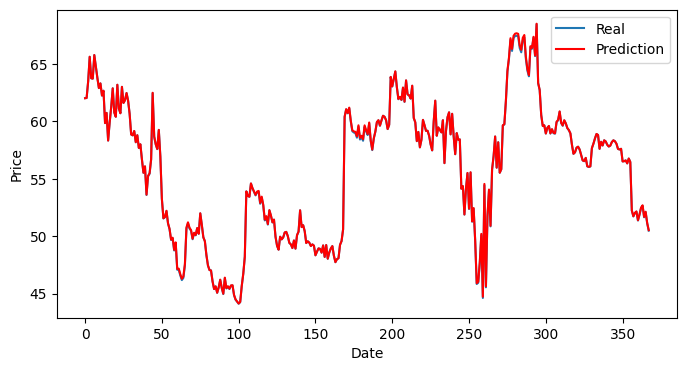

In [53]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(test_R)), test_R, label='Real')
plt.plot(range(len(forecasts_inverted)), forecasts_inverted, label='Prediction', color = 'red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()